## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\Bobson\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [24]:
from keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from keras.regularizers import l1 , l2 , l1_l2
from keras.models import Model


def build_mlp_regular_l2(input_shape , output_shape=10, num_nur = [512,256,128], regular=0.0001):
    """Code Here
    建立你的神經網路
    """
    #reg = regular_type(regular)
    inp = Input(input_shape)
    
    for i , n_nur in enumerate(num_nur):
        if i == 0:
            x = Dense(activation = 'relu', units = n_nur, kernel_regularizer = l2(regular), name = 'hidden_layer'+str(i+1))(inp)
        else:
            x = Dense(activation = 'relu', units = n_nur, kernel_regularizer = l2(regular), name = 'hidden_layer'+str(i+1))(x)
            
    output = Dense(activation = 'softmax', units = output_shape, name = 'output_layer')(x)
    
    model = keras.models.Model(inputs=[inp], outputs = [output]) 
            
    return model


def build_mlp_Dropout(input_shape, output_dim=10, num_nur = [512,256,128]):
    """Code Here
    建立你的神經網路
    """
    inp = Input(input_shape)
    for i , nur in enumerate(num_nur):
        if i == 0:
            x = Dense(activation = 'relu',units = nur ,name = "hidden_layer"+str(i+1))(inp)
            x = Dropout(0.2)(x)
        else:
            x = Dense(activation = 'relu', units = nur,name = "hidden_layer"+str(i+1))(x)
            x =Dropout(0.2)(x)
    output = Dense(activation = 'softmax', units = output_dim, name = 'Output_Layer')(x)
    model = Model(inputs =[inp], outputs = [output])
    return model

def build_mlp_BatchNormalization(input_shape, output_dim=10, num_nur = [512,256,128]):
    """Code Here
    建立你的神經網路
    """
    inp = Input(input_shape)
    for i , nur in enumerate(num_nur):
        if i == 0:
            x = Dense(units = nur, name = "hidden_layer"+str(i+1))(inp)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        else:
            x = Dense(units = nur, name = "hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
    output = Dense(activation = 'softmax', units = output_dim, name = 'Output_Layer')(x)
    model = Model(inputs =[inp], outputs = [output])
    return model

Activation('tanh')

In [25]:
"""Code Here
設定超參數
"""
learning_rate = 0.001
epochs = 50
batch_size = 256
momentum = 0.95
model_str = [build_mlp_regular_l2, build_mlp_Dropout, build_mlp_BatchNormalization]
model_str_label = ['build_mlp_regular_l2', 'build_mlp_Dropout', 'build_mlp_BatchNormalization']

In [26]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for i in range(len(model_str)):
    keras.backend.clear_session()
    model = model_str[i](input_shape=x_train.shape[1:])
    model.summary()
    opt = keras.optimizers.SGD(lr = learning_rate, momentum = momentum, nesterov = True)
    model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = opt)
    model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data=(x_test,y_test), shuffle = True)
   
    
    train_loss = model.history.history['loss']
    train_accuracy = model.history.history['acc']
    valid_loss = model.history.history['val_loss']
    valid_accuracy = model.history.history['val_acc']
    results['experement_batch_size:'+str(model_str_label[i])] = {'train_loss': train_loss, 'train_accuracy':train_accuracy, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy}


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 133us/step - loss: 2.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 167us/step - loss: 2.1741 - acc: 0.1911 - val_loss: 1.9803 - val_acc: 0.2950
Epoch 2/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.9764 - acc: 0.2800 - val_loss: 1.8594 - val_acc: 0.3389
Epoch 3/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.8860 - acc: 0.3201 - val_loss: 1.7850 - val_acc: 0.3714
Epoch 4/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.8316 - acc: 0.3407 - val_loss: 1.7357 - val_acc: 0.3814
Epoch 5/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.7896 - acc: 0.3601 - val_loss: 1.6933 - val_acc: 0.4043
Epoch 6/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.7520 - acc: 0.3731 - val_loss: 1.6549 - val_acc: 0.4165
Epoch 7/50
50000/50000 [==============================] - 8s 161us/step - loss: 1.7211 - acc: 0.3840 - val_loss: 1.6296 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.8636 - acc: 0.3472 - val_loss: 1.7241 - val_acc: 0.3872
Epoch 2/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.5424 - acc: 0.4604 - val_loss: 1.6067 - val_acc: 0.4288
Epoch 3/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.4286 - acc: 0.5002 - val_loss: 1.5205 - val_acc: 0.4562
Epoch 4/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.3445 - acc: 0.5297 - val_loss: 1.4768 - val_acc: 0.4765
Epoch 5/50
50000/50000 [==============================] - 9s 179us/step - loss: 1.2699 - acc: 0.5585 - val_loss: 1.4745 - val_acc: 0.4816
Epoch 6/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.2069 - acc: 0.5809 - val_loss: 1.4586 - val_acc: 0.4828
Epoch 7/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.1432 - acc: 0.6058 - val_loss: 1.4540 - 

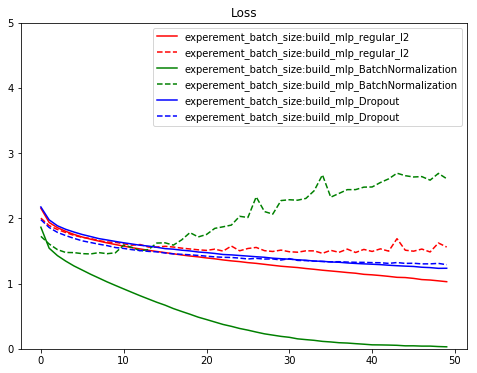

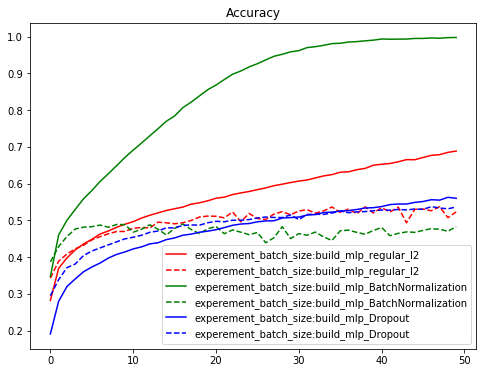

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_accuracy'])),results[cond]['train_accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_accuracy'])),results[cond]['valid_accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()